# Lab 03 - Gaussian Process Modeling
## Tasks
- Construct a Gaussian Process model using GPyTorch and tune hyperparameters of GP model given noisy data
- Construct Gaussian Process models using the Xopt package
- Gaussian Process model visualization and sampling

# Imports

In [2]:
!pip install botorch==0.12.0 gpytorch xopt==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 

In [3]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

import torch
import gpytorch

# Gaussian Process modeling

## Generate Data (1D)
We are going to look at some data generated by random sampling in the domain [0,1]. The function that generated this data is

$$
f(x) = \sin(2\pi x) + x
$$

The columns of the array is $(x)$. We need to convert it to a torch tensor to use with GPyTorch.

In [32]:
x = np.random.rand(5)
train_x = x.reshape(-1,1)
train_y = np.sin(2*np.pi*train_x[:,0]) + train_x[:,0] + np.random.randn(train_x.shape[0]) * 0.01

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

## Define a GP Model in GPyTorch
Here we define an Exact GP model using GPyTorch. The model is exact because we have analytic expressions for the integrals associated with the GP likelihood and output distribution. If we had a non-Gaussian likelihood or some other complication that prevented analytic integration we can also use Variational/Approximate/MCMC techniques to approximate the integrals necessary.

Taking a close look at the model below we see two important modules:
- ```self.mean_module``` which represents the mean function
- ```self.covar_module``` which represents the kernel function (or what is used to calculate the kernel matrix

Both of these objects are torch.nn.Module objects (see https://pytorch.org/docs/stable/generated/torch.nn.Module.html). PyTorch modules have trainable parameters which we can access when doing training. By grouping the modules inside another PyTorch module (gpytorch.models.ExactGP) lets us easily control which parameters are trained and which are not.

In [33]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_f, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_f, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Here we initialize our model with the training data and a defined likelihood (also a nn.Module) with a trainable noise parameter.

In [34]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

for name, val in model.named_parameters():
  print(name, val)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)


NOTE: All PyTorch modules (including ExactGPModel) have ```.train()``` and ```.eval()``` modes. ```train()``` mode is for optimizing model hyperameters. ```.eval()``` mode is for computing predictions through the model posterior.

## Training the model
Here we train the hyperparameters of the model (the parameters of the covar_module and the mean_module) to maximize the marginal log likelihood (minimize the negative marginal log likelihood). Note that since everything is defined in pyTorch we can use Autograd functionality to get the derivatives which will speed up optimization using the modified gradient descent algorithm ADAM.

Also note that several of these hyperparameters (lengthscale and noise) must be strictly positive. Since ADAM is an unconstrained optimizer (which optimizes over the domain (-inf, inf)) gpytorch accounts for this constraint by optimizing the log of the lengthscale (raw_lengthscale). To get the actual lengthscale just use ```model.covar_module.base_kernel.lengthscale.item()```

### **Task:**

Write the steps for minimizing the negative log likelihood using pytorch. Refer back to Lab 1 for a reminder of how to do this. Use `gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)` as the loss function (which we are trying to maximize!). Use your function to train the model and report the marginal log likelihood.


In [35]:
def train_model(model, likelihood):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # create model object and necessary training components
    criterion = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # gradient descent

    # Initial hyperparameter
    print("init hypeparams")
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    print("")

    # Training loop
    epochs = 2000
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        pred_y = model(train_x)
        loss = -criterion(pred_y, train_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    print("")
    print("final hypeparams")
    #print the new trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')

    return loss

In [36]:
nmll = train_model(model, likelihood)

init hypeparams
likelihood.noise_covar.raw_noise : Parameter containing:
tensor([0.], requires_grad=True)
mean_module.raw_constant : Parameter containing:
tensor(0., requires_grad=True)
covar_module.raw_outputscale : Parameter containing:
tensor(0., requires_grad=True)
covar_module.base_kernel.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)

Epoch 100/2000, Loss: 0.8139
Epoch 200/2000, Loss: 0.6996
Epoch 300/2000, Loss: 0.5271
Epoch 400/2000, Loss: 0.4450
Epoch 500/2000, Loss: 0.3371
Epoch 600/2000, Loss: 0.2381
Epoch 700/2000, Loss: 0.1636
Epoch 800/2000, Loss: 0.1125
Epoch 900/2000, Loss: 0.0794
Epoch 1000/2000, Loss: 0.0587
Epoch 1100/2000, Loss: 0.0459
Epoch 1200/2000, Loss: 0.0380
Epoch 1300/2000, Loss: 0.0329
Epoch 1400/2000, Loss: 0.0295
Epoch 1500/2000, Loss: 0.0271
Epoch 1600/2000, Loss: 0.0254
Epoch 1700/2000, Loss: 0.0242
Epoch 1800/2000, Loss: 0.0232
Epoch 1900/2000, Loss: 0.0225
Epoch 2000/2000, Loss: 0.0219

final hypeparams
likelihood.noise_cov

## Plot the 1D model probability distribution

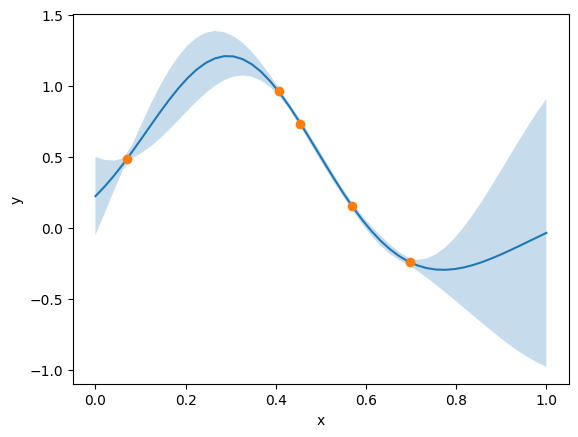

In [37]:
#plot the gp distribution in the normalized range
x = torch.linspace(0, 1, 50).double()
model.eval()
with torch.no_grad():
    p = model(x)

    #get the mean
    m = p.mean

    #get the 2 sigma confidence region around the mean
    l,u = p.confidence_region()

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
#plot mean and confidence region
ax.plot(x, m)
ax.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

#plot samples
ax.plot(train_x, train_y,'oC1')

## Plot the samples from the model

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


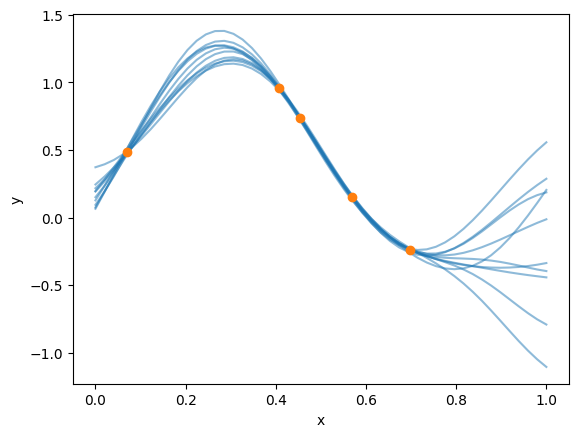

In [38]:
#use the normalized range
x = torch.linspace(0, 1, 50).double()
#specify number of samples
n_samples = 10
model.eval()
with torch.no_grad():
    p = model(x)
    s = p.rsample(torch.Size([n_samples]))

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')

#plot samples from posterior model
for sample in s:
    ax.plot(x, sample,'C0',alpha = 0.5)

#plot measurements
ax.plot(train_x, train_y,'oC1')

## Building and visualizing models in Xopt
Xopt builds models in Botorch, which has a separate class for GP modeling that loosely wraps ExactGP classes. Visualizing the model has some slight differences.

In [39]:
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt import VOCS
import pandas as pd

vocs = VOCS(variables={"x":[0,1]}, observables=["y"])
data = pd.DataFrame({"x":train_x.flatten().numpy(), "y":train_y.flatten().numpy()})

# define a model constructor
model_constructor = StandardModelConstructor()
xopt_gp_model = model_constructor.build_model_from_vocs(
    vocs=vocs,
    data=data,
)

(<Figure size 600x200 with 1 Axes>,
 array([[<Axes: xlabel='x', ylabel='y'>]], dtype=object))

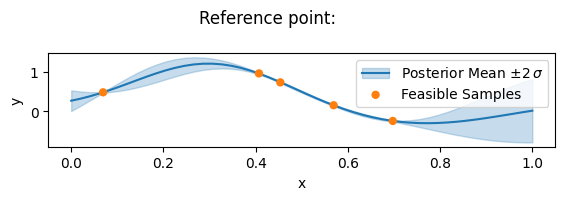

In [40]:
from xopt.generators.bayesian.visualize import visualize_model
visualize_model(xopt_gp_model, vocs, data)

## Generate Data (3D)
We are going to look at some data that was generated by sampling a 5 x 5 x 5 grid in the domain [0,1] on each axis. The function that generated this data is

$$
f(x_1,x_2,x_3) = \sin(2\pi x_1)\sin(\pi x_2) + x_3
$$

The columns of the imported array is $(x_1,x_2,x_3,f)$. We need to convert it to a torch tensor to use with GPyTorch.

In [56]:
x = np.linspace(0,1,5)
xx = np.meshgrid(x,x,x)
train_x = np.vstack([ele.ravel() for ele in xx]).T
train_y = np.sin(2*np.pi*train_x[:,0]) * np.sin(np.pi*train_x[:,1]) + train_x[:,2] + np.random.randn(train_x.shape[0]) * 0.01

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

### **Task:**
Define a new GP model that uses a different kernel (or combination of kernels) to maximize the marginal log likelihood.


In [57]:
class MyExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(active_dims=0) *\
            gpytorch.kernels.PeriodicKernel(active_dims=1)) +\
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(active_dims=2))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [64]:
# train the model
# YOUR CODE HERE
my_likelihood = gpytorch.likelihoods.GaussianLikelihood()
my_model = MyExactGPModel(train_x, train_y, likelihood)

my_nmll = train_model(model, likelihood)

init hypeparams
likelihood.noise_covar.raw_noise : Parameter containing:
tensor([-10.9626], requires_grad=True)
mean_module.raw_constant : Parameter containing:
tensor(0.0215, requires_grad=True)
covar_module.kernels.0.raw_outputscale : Parameter containing:
tensor(-2.4673, requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.0.raw_lengthscale : Parameter containing:
tensor([[-2.7225]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.0.raw_period_length : Parameter containing:
tensor([[-0.0202]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.1.raw_lengthscale : Parameter containing:
tensor([[8.3040]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.1.raw_period_length : Parameter containing:
tensor([[0.8642]], requires_grad=True)
covar_module.kernels.1.raw_outputscale : Parameter containing:
tensor(0.4934, requires_grad=True)
covar_module.kernels.1.base_kernel.raw_variance : Parameter containing:
tensor([[0.4934]], requires_grad=

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Epoch 100/2000, Loss: 0.8456
Epoch 200/2000, Loss: 0.8455
Epoch 300/2000, Loss: 0.8455
Epoch 400/2000, Loss: 0.8455
Epoch 500/2000, Loss: 0.8455
Epoch 600/2000, Loss: 0.8455
Epoch 700/2000, Loss: 0.8455
Epoch 800/2000, Loss: 0.8455
Epoch 900/2000, Loss: 0.8455
Epoch 1000/2000, Loss: 0.8455
Epoch 1100/2000, Loss: 0.8455
Epoch 1200/2000, Loss: 0.8455
Epoch 1300/2000, Loss: 0.8455
Epoch 1400/2000, Loss: 0.8455
Epoch 1500/2000, Loss: 0.8455
Epoch 1600/2000, Loss: 0.8455
Epoch 1700/2000, Loss: 0.8455
Epoch 1800/2000, Loss: 0.8455
Epoch 1900/2000, Loss: 0.8455
Epoch 2000/2000, Loss: 0.8455

final hypeparams
likelihood.noise_covar.raw_noise : Parameter containing:
tensor([-10.9626], requires_grad=True)
mean_module.raw_constant : Parameter containing:
tensor(0.0215, requires_grad=True)
covar_module.kernels.0.raw_outputscale : Parameter containing:
tensor(-2.4740, requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.0.raw_lengthscale : Parameter containing:
tensor([[-2.7591]], require

### Use the code below to visualize the model.


In [65]:
#Hint: you can use the following code to get the points to be evaluated
import torch
n = 50
x = torch.meshgrid(torch.linspace(0,1,n), torch.linspace(0,1,n))
pts = torch.vstack([ele.flatten() for ele in x]).T
pts = torch.hstack((pts, torch.zeros((n**2,1)))).unsqueeze(1)

pts.shape

torch.Size([2500, 1, 3])

In [66]:
# evaluate the model and get the mean + variance
my_model.eval()

with torch.no_grad():
    post = my_likelihood(my_model(pts))
    mean = post.mean
    variance = post.variance

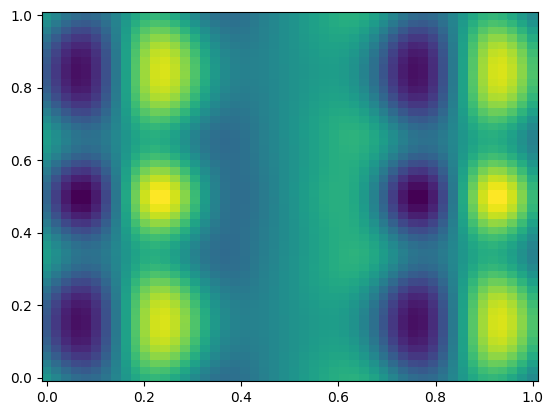

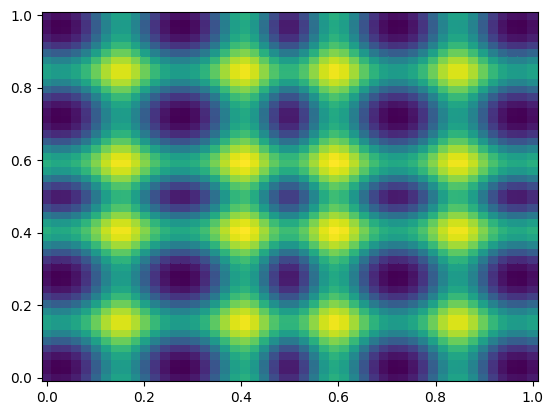

In [67]:
# plot the model
fig, ax = plt.subplots()
ax.pcolor(*x, mean.reshape(n,n))
fig, ax = plt.subplots()
ax.pcolor(*x, variance.reshape(n,n))
